In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.utils import resample

plt.style.use('seaborn-whitegrid')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_46609/1434324886.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


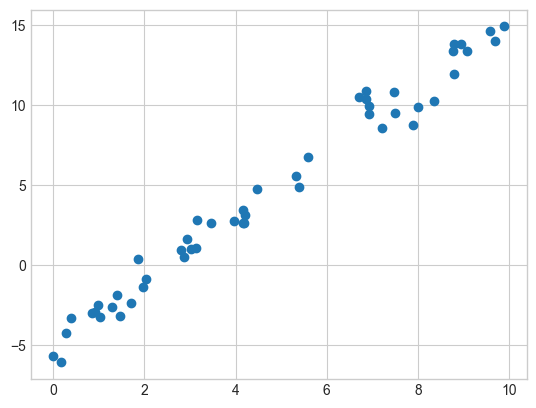

In [2]:
# the most simple limnear regression model is y = ax + b
# consider a slope of 2 and an intercept of -5
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y)

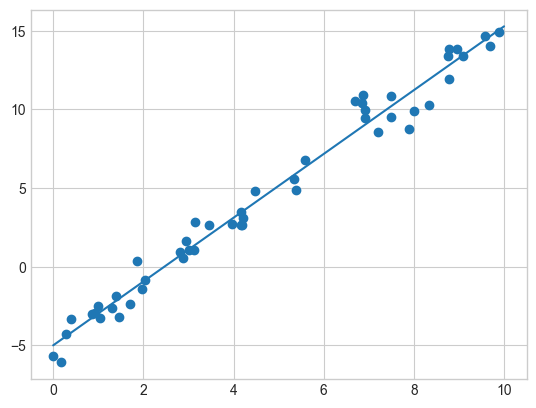

In [3]:
# we can use sklearn estimator to fit the data
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit)

In [4]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.0272088103606967
Model intercept: -4.9985770855532135


In [5]:
# we can see that the results are very close to the inputs
# we cna also do a multi-dimension linear regression
# the multi-dimensional nature of such regressions makes them more difficult to visualize
# but we can see the results using the following code
rng = np.random.RandomState(1)
x = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(x, [1.5, -2.0, 1.0])
model.fit(x, y)
print(model.intercept_)
print(model.coef_)
# here the y data is constructed from a linear combination of three x values and the linear regression recovers these coefficients used to construct the data within a small margin of error

0.4999999999999984
[ 1.5 -2.   1. ]


In [6]:
# basis function regression
# one trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to basis functions
# polynomial basis functions
# this polynomial projection is useful enough that it is built into scikit-learn, using the PolynomialFeatures transformer
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

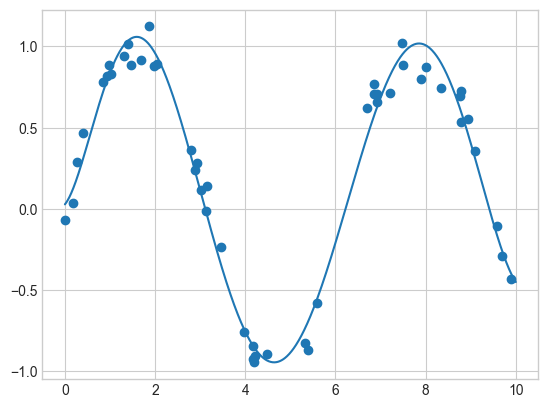

In [7]:
# we see there that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value
# the cleanest way to accomplish this is to use a pipeline
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())
# with this transformation in place we can use the linear model to fit much more complicated relationships between x and y
# this is a sine wave with noise for example
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

Gaussian basis functions

(0.0, 10.0)

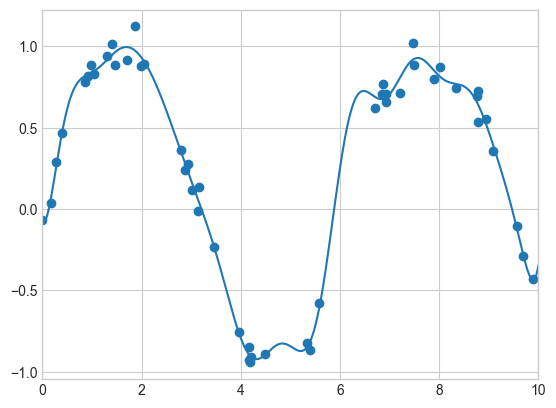

In [8]:
# other basis functions are possible for example one useful pattern is to fit a model that is not a sum of polynomial bases but a sum of Gaussian bases
# these gaussian basis functions are not built into scikit-learn but we can write a custom transformer that will create them
class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""

    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg**2, axis))

    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self

    def transform(self, X):
        return self._gauss_basis(
            X[:, :, np.newaxis], self.centers_, self.width_, axis=1
        )


gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10)

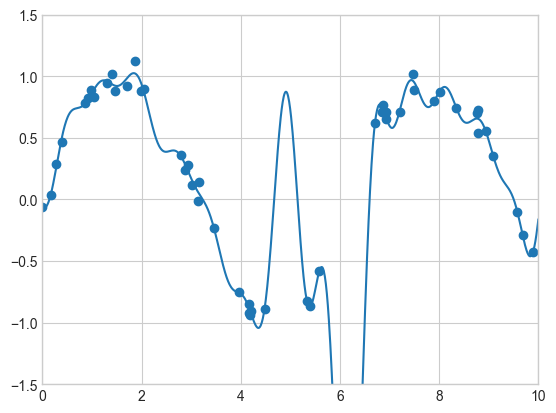

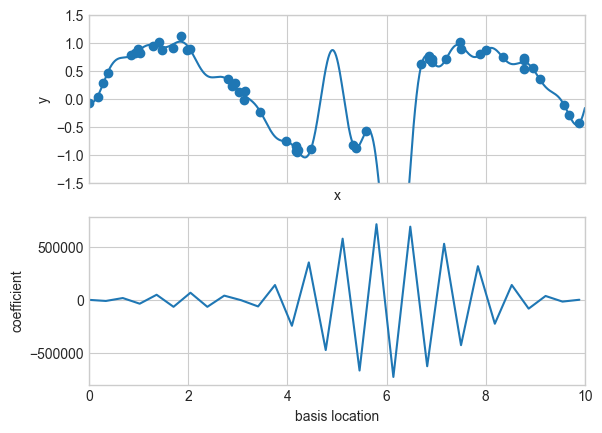

In [9]:
# the introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting unless we have a good way to control the model complexity
# the following figure shows what happens if we use a large number of gaussian basis functions
model = make_pipeline(GaussianFeatures(30), LinearRegression())
model.fit(x[:, np.newaxis], y)
plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)


# with the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to the extreme values between locations where it is constrained by data we can see the reason for this if we plot the copeeficients of the gaussian bases with respect to their locations
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel="x", ylabel="y", ylim=(-1.5, 1.5))

    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_, model.steps[1][1].coef_)
    ax[1].set(xlabel="basis location", ylabel="coefficient", xlim=(0, 10))


model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)
# the lower panel of this fugure shows that the amplitude of the basis functions at each location. This is typical overfitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out. We know that such behavior is problematic, and it would be nice if we could limit such spikes explicitly in the model by penalizing large values of the model parameters. Such a penalty is known as regularization, and comes in several forms

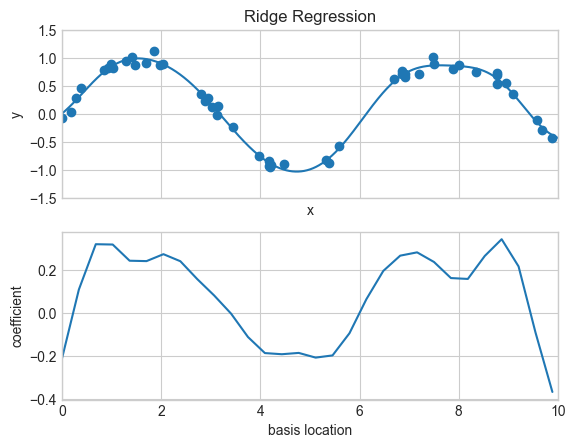

In [10]:
# ridge regression (L2 regularization)
# by penalizing the sum of squars (2-norms) of the model coefficients, ridge regression forces the model to fit the data but also keeps the model weights as small as possible
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title="Ridge Regression")
# the alpha parameter is essentially a knob controlling the complexity of the resulting model. in the limit alpha goes to zero we recover the standard linear regression result; in the limit alpha goes to infinity all model responses will be suppressed. one advantage of ridge regression in particular is that it can be computed very efficiently at hardly more computational cost than the original linear regression model

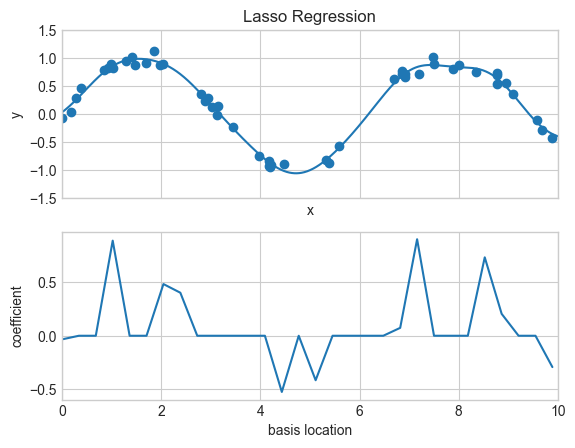

In [11]:
# lasso regression (L1 regularization)
# another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients
# lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001, max_iter=2000))
basis_plot(model, title="Lasso Regression")
# with the lassoo regression penalty, the majority of the coefficents are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions

In [12]:
# example: predicting bicycle traffic
# as an example lets take a look at whether we can predict the number of bicycle trips across Seattle's Fremont bridge based on weather, season, and other factors
# we will join the bike data with another dataset and try to determine the extent to which weather and seasonal factors - temperature, precipitation, and daylight hours - affect the volume of bicycle traffic through this corridor
counts = pd.read_csv("Data/FremontBridge.csv", index_col="Date", parse_dates=True)
weather = pd.read_csv("Data/SeattleWeather.csv", index_col="DATE", parse_dates=True)
# for simplicity we will focus on data prior to 2020 in order to avoid complications from the coronavirus pandemic in the data
counts = counts[counts.index < "2020-01-01"]
weather = weather[weather.index < "2020-01-01"]
# next we will compute the total daily bicycle traffic, and put this in its own dataframe
daily = counts.resample("d").sum()
daily["Total"] = daily.sum(axis=1)
daily = daily[["Total"]]  # remove other columns
# we saw that patters of use generally vary from day to day. let's account for this in our data by adding binary columns that indicate the day of the week
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [13]:
# we may aslo expect riders to behave differently on holidays; let's add an indicator of this as well
cal = USFederalHolidayCalendar()
holidays = cal.holidays("2012", "2020")
daily = daily.join(pd.Series(1, index=holidays, name="holiday"))
daily["holiday"].fillna(0, inplace=True)

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_46609/3863889116.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


(8.0, 17.0)

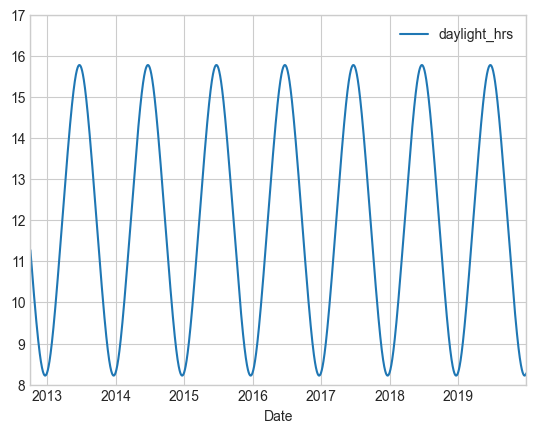

In [14]:
# we also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = 1.0 - np.tan(np.radians(latitude)) * np.tan(
        np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)
    )
    return 24.0 * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.0


daily["daylight_hrs"] = list(map(hours_of_daylight, daily.index))
daily[["daylight_hrs"]].plot()
plt.ylim(8, 17)

In [15]:
# we can also add the average temperature and total precipitation to the data in addition to the inches of precipitation, we will add a flag that indicates whether a day is dry (has zero precipitation)
weather["Temp (F)"] = 0.5 * (weather["TMIN"] + weather["TMAX"])
weather["Rainfall (in)"] = weather["PRCP"]
weather["dry day"] = (weather["PRCP"] == 0).astype(int)

daily = daily.join(weather[["Rainfall (in)", "Temp (F)", "dry day"]])

In [16]:
# finally we can add a counter that increases from day 1 and measures how many years have passed. this will let us measure any observed annual increase or decrease in daily crossings
daily["annual"] = (daily.index - daily.index[0]).days / 365.0
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Rainfall (in),Temp (F),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,56.0,1,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,56.5,1,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,59.5,1,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,60.5,1,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,60.5,1,0.010959


In [18]:
# with this in place, we can choose the columns to use and fit a linear regression model to our data we will set fit_intercept=False, because the daily indicator columns essentially operate as their own day-specific intercepts
daily.dropna(axis=0, how="any", inplace=True)
column_names = [
    "Mon",
    "Tue",
    "Wed",
    "Thu",
    "Fri",
    "Sat",
    "Sun",
    "holiday",
    "daylight_hrs",
    "Rainfall (in)",
    "dry day",
    "Temp (F)",
    "annual",
]
X = daily[column_names]
y = daily["Total"]
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily["predicted"] = model.predict(X)

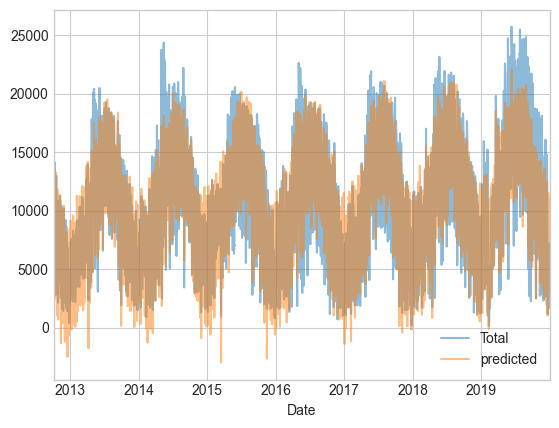

In [19]:
# finally, we can compare the total and predicted bicycle traffic visually
daily[["Total", "predicted"]].plot(alpha=0.5)

In [20]:
# from the fact that the data and model predictions dont line up exactly we can infer that there are more factors at play than the ones we have included here either our features are not complete or there are some non linear relationships that we are not capturing with our model(perhaps people ride less at both high and low temperatures). nevertheless, our rough approximation is enough to capture quite a lot of signal in the data: we see here that our very simple model does quite well! we can look at the coefficients of the model to estimate how much each of these features contributes to the daily bicycle count
params = pd.Series(model.coef_, index=X.columns)
params

Mon              -3309.953439
Tue              -2860.625060
Wed              -2962.889892
Thu              -3480.656444
Fri              -4836.064503
Sat             -10436.802843
Sun             -10795.195718
holiday          -5006.995232
daylight_hrs       409.146368
Rainfall (in)    -2789.860745
dry day           2111.069565
Temp (F)           179.026296
annual             324.437749
dtype: float64

In [21]:
# these are difficult to interpret without some measure of their uncertainty we can compute these uncertainties quickly using bootstrap resamplings of the data
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

In [22]:
# with the errors estimated we can more fully interpret the model results
print(pd.DataFrame({"effect": params.round(0), "error": err.round(0)}))

                effect  error
Mon            -3310.0  265.0
Tue            -2861.0  274.0
Wed            -2963.0  268.0
Thu            -3481.0  268.0
Fri            -4836.0  261.0
Sat           -10437.0  259.0
Sun           -10795.0  267.0
holiday        -5007.0  401.0
daylight_hrs     409.0   26.0
Rainfall (in)  -2790.0  186.0
dry day         2111.0  101.0
Temp (F)         179.0    7.0
annual           324.0   22.0


In [ ]:
# the effect column here roughly speaking shows how the number of riders is affected by a change of the feature in question. for example, there is a clear divide when it comes to the day of the week: there are thousands of fewer riders on weekends than on weekdays. we also see that for each additional hour of daylight 409 +- 26 more people choose to ride. a temp increase of one degree fahrenheit encourages 179 =- 7 people to ride a dry day means 2790 choose another mode of transport once all of these have been accounted for we see an increase of 324 =- 22 nwe riders per year

# we are missing some relevent information, for example, as metioned erlier, nonlinear effects and non linear trends within each variable cannot be accounted for with this model. we are also missing some potentially relevent information, such as wind speed, precipitation type, and other factors. nevertheless, this very simple model captures many of the basic trends in the data, and is enough to clearly identify several of the key factors affecting daily bicycle counts in the Fremont bridge